In [1]:
import os
from pathlib import Path
from collections import defaultdict
from tqdm import tqdm
import random
from typing import List

import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import torch
from torch import nn, Tensor
import torch.nn.functional as F
import networkx as nx

import extension as ext
from extension import utils
from segmentation.tree_segmentation.tree_2d_segmentation import TreeStructure
from segmentation.tree_segmentation.tree_3d_segmentation import Tree3D

%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
device = torch.device('cuda')

# 一. 生成大量二维树分割结果

- 给定一个mesh $S$
- 在制定范围内生成$K$个视角$\{\pi_i\}_i^{K}$, 每个视角渲染一张图片$I_i$及像素与三角面片间的对应关系$C_i$: $$I_i, C_i = \mathrm{render}(S, \pi_i)$$
- 对每张图片$I_i$进行二维树分割, 得到结果$T^{2d}_i = \{m_j\}_{j=1}^{N_i}$, 其中$N_i$表示分割结果的数量

In [38]:
def color_mask(mask, max_value=None):
    if isinstance(mask, Tensor):
        mask = mask.cpu().numpy()
    if max_value is None:
        max_value = mask.max()
    cmap = matplotlib.colormaps['viridis'].resampled(max_value + 2)
    mask_image = cmap(mask)
    mask_image = np.where(mask[:, :, None] == 0, 1., mask_image)
    return mask_image[..., :3].astype(np.float32)


def image_add_points(image: np.ndarray, points: np.ndarray, s=5):
    if points.max() <= 1.1:
        points = points * np.array([image.shape[1], image.shape[0]])
    image = image.copy()
    H, W = image.shape[:2]
    for i in range(points.shape[0]):
        x, y = points[i]
        for dx in range(-s, s + 1):
            for dy in range(-s, s + 1):
                if dx * dx + dy * dy <= s * s and 0 <= x + dx < W and 0 <= y + dy < H:
                    image[int(y + dy), int(x + dx), :] = np.array((1., 0, 0))
    return image


def image_add_mask_boundary(image: np.ndarray, mask: Tensor):
    mask = F.interpolate(mask[None, None, :, :].float(), size=image.shape[:2], mode='nearest')
    boundary = F.avg_pool2d(mask, 7, 1, 3)
    boundary = torch.logical_and(boundary.ne(mask), mask).cpu().numpy()[0, 0]
    image = image.copy()
    image[boundary, :3] = (255, 0, 0)
    return image


def show_masks(image, *masks):
    all_masks = []
    for mask in masks:
        # if isinstance(mask, (TreeData, MaskData)):
        #     mask = mask['masks']
        # elif isinstance(mask, dict):
        #     mask = mask['segmentation']
        if isinstance(mask, torch.Tensor):
            mask = mask.cpu().numpy()
        if mask.ndim == 2:
            all_masks.append(mask[None])
        else:
            assert mask.ndim == 3
            all_masks.append(mask)
    if len(all_masks) == 0:
        assert image is not None
        one_mask = np.zeros(image.shape[:2], dtype=np.int32)
    else:
        all_masks = np.concatenate(all_masks, axis=0)
        one_mask = np.sum(all_masks.astype(np.uint8) * np.arange(1, all_masks.shape[0] + 1)[:, None, None], axis=0)
    if image is not None:
        if isinstance(image, Tensor):
            image = utils.as_np_image(image)
        plt.imshow(image)
        alpha = 0.356
    else:
        plt.imshow(np.ones((*one_mask.shape, 3), dtype=np.uint8) * 255)
        alpha = 1
    ax = plt.gca()
    ax.set_autoscale_on(False)
    # for m in all_masks:
    #     img = np.ones((m.shape[0], m.shape[1], 3))
    #     color_mask = np.random.random((1, 3)).tolist()[0]
    #     for i in range(3):
    #         img[:, :, i] = color_mask[i]
    # ax.imshow(np.dstack((img, m * 0.35)))
    cmap = matplotlib.colormaps['viridis'].resampled(len(all_masks) + 2)
    mask_image = cmap(one_mask)
    mask_image[..., -1] = alpha
    mask_image = np.where(one_mask[:, :, None] == 0, 0., mask_image)
    # mask_image = mask_image * (one_mask[:, :, None])
    # print(mask_image.shape, mask_image.min(), mask_image.max())
    plt.imshow(mask_image)
    # ax.imshow(one_mask, cmap=matplotlib.colormaps['viridis'], alpha=0.35)
    plt.axis('off')
    # plt.show()

In [3]:
## tang_table
# save_root = Path('~/wan_code/segmentation/segment_anything/results/12612b82ea88a8977007b330cacd9453').expanduser()
## table and chairs
# save_root = Path('~/wan_code/segmentation/segment_anything/results/c44102ae857d5428fa4e91279f4e43e1').expanduser()
## chairs
save_root = Path('~/wan_code/segmentation/segment_anything/results/cbec970966b1cfc31013390074d5de0a').expanduser()
seg_2d_files = sorted(list(save_root.glob('*.data')))
print(f'There are {len(seg_2d_files)} data')
data = [torch.load(filename, map_location=device) for filename in seg_2d_files]
print(utils.show_shape(data[0]))

There are 100 data
{'tree_data': {'masks': IntTensor[4, 1024, 1024], 'iou_preds': F32Tensor[17], 'points': F64Tensor[17, 2], 'stability_score': F32Tensor[17], 'boxes': F32Tensor[17, 4], 'area': LongTensor[17], 'parent': IntTensor[18], 'first': IntTensor[18], 'next': IntTensor[18], 'last': IntTensor[18], 'cnt': 17, 'num_samples': IntTensor[18], 'extra': {}}, 'image': numpy((1024, 1024, 3), float32), 'tri_id': IntTensor[1024, 1024], 'Tw2v': F32Tensor[4, 4]}


In [4]:
all_masks = []
# all_masks_info = []
# all_masks_loc = []
for k in range(len(data)):
    masks = data[k]['tree_data']['masks']
    all_masks_k = []
    # all_masks_info.append([])
    # all_masks_loc.append({})
    for i in range(1, len(masks)):
        for j in masks[i].unique():
            j = j.item()
            if j <= 0:
                continue
            all_masks_k.append(masks[i] == j)
            # all_masks_info[k].append((i, j))
            # all_masks_loc[k][j] = (i, (masks[i] == j).sum().item())
    all_masks.append(torch.stack(all_masks_k))
print(utils.show_shape(all_masks[0]), len(all_masks), 'num_masks:', sum(len(x) for x in all_masks))

BoolTensor[15, 1024, 1024] 100 num_masks: 1488


In [5]:
# print(list(save_root.glob('*')))
mesh = torch.load(list(save_root.glob('*.mesh_cache'))[0])
print(mesh)
num_faces = mesh.f_pos.shape[0]
v3 = mesh.v_pos[mesh.f_pos]  # shape: (F, 3, 3)
tri_area = torch.cross(v3[:, 0] - v3[:, 1], v3[:, 0] - v3[:, 2], dim=-1).norm(dim=-1) * 0.5
del v3
# num_faces = 72014
print('num faces:', num_faces)

Mesh(vertices=42485, faces=84762, tex, nrm, tng, mat=['kd', 'ks', 'bsdf', 'ka', 'name'])
num faces: 84762


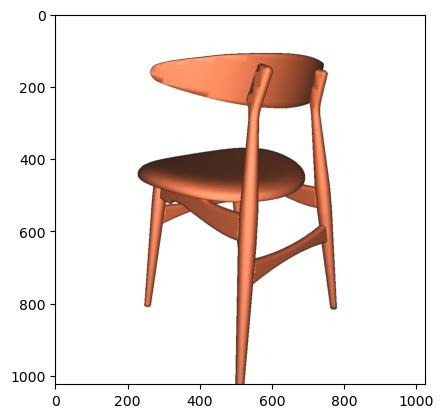

In [6]:
plt.imshow(data[2]['image'].clip(0, 1))

# 三维树分割
将 $\{m^i_j\}$ 划分为$L$个类$M_l = \{m^l_1, m^l_2, \dots, m^l_{Nm_l}\}$, 使得下式最大化
$$\mathcal{L} = \frac{1}{L} \sum_{l=1}^{L}\frac{1}{Nm_l}\sum_{i=1}^{Nm_l}\mathrm{IoU}(m^l_i, P(M_l, \pi^l_i))$$
其中, $\pi^l_i$表示$m^l_i$对应的视角, $P(M, \pi)$表示三维分割$M$在视角$\pi$下的投影

当$M_l$对应的分割结果$\{m^l_1, m^l_2, \dots, m^l_{Nm_l}\}$固定时, $M_l$包含的三角面片为:
$$M_l = \{x \mid \frac{\sum{area(x, C_i \cdot m^l_i)}}{\sum{area(x, C_i)}} \ge 0.5\}$$

从$M_1, \dots, M_L$ ~选择~ $N_T$ ~个结点~组成一棵树$\mathbf{T}=\{T_i\}_{i=1}^{N_T}$, 使得最优化下式:
$$\mathcal{L}_{T} = \frac{1}{K} \sum_{k=1}^{K} p(T^{2d}_k \mid \mathbf{T})$$
$$p(T^{2d}_k \mid \mathbf{T}) =\frac{1}{N_k+N_T}( \sum_{j=1}^{N_k}\max_{i=1}^{N_T}\mathrm{IoU}(m^k_j, T^k_i) + \sum_{i=1}^{N_T}\max_{j=1}^{N_k}\mathrm{IoU}(m^k_j, T^k_i))$$
其中$T^k_i = P(T_i, \pi_k)$

最大化树结构评分: 兄弟结点互不重叠, 结点全部在父结点中
$$\mathcal{L}_{tree} = \frac{1}{C}\left(\sum_{p_i = p_j}1- \mathrm{IoU}(T_i, T_j) + \sum_{i}{\mathrm{In}(T_i, T_{p_i})}\right)$$

# 方案二

设定最大节点数$N$, 训练参数$M_1, \dots, M_N$

将所有二维分割结果分类 $\mathbf{c} = GCN(A, X)$, $$\mathcal{L}_c = CE(\mathbf{c}, \mathrm{IoU}(M_i, m_i))$$

令$T = \mathrm{make\_tree}\left( \{M_i \mid \exists k, \arg\max_j c_{kj} = i\} \right)$


In [36]:
tri_uni = []
mask_gt = []
tmp = torch.zeros(mesh.f_pos.shape[0] + 1, dtype=torch.float, device=device)
for i, data_i in enumerate(data):
    uni_i, cnt_i = data_i['tri_id'].unique(return_counts=True)
    if uni_i[0] == 0:
        uni_i, cnt_i = uni_i[1:], cnt_i[1:]
    tri_uni.append((uni_i, cnt_i))
    mask_gt_i = torch.zeros((all_masks[i].shape[0], tri_uni[i][0].shape[0]), device=device)
    for j, mask in enumerate(all_masks[i]):
        mask_tri, tri_cnts = data_i['tri_id'][mask].unique(return_counts=True)
        tmp.zero_()
        tmp[mask_tri] = tri_cnts.float()
        mask_gt_i[j] = tmp[uni_i] / cnt_i.float()
    mask_gt.append(mask_gt_i)
print(len(tri_uni), utils.show_shape(tri_uni[0]))
print(len(mask_gt), utils.show_shape(mask_gt[0]))

100 (IntTensor[24882], LongTensor[24882])
100 F32Tensor[15, 24882]
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.], device='cuda:0')


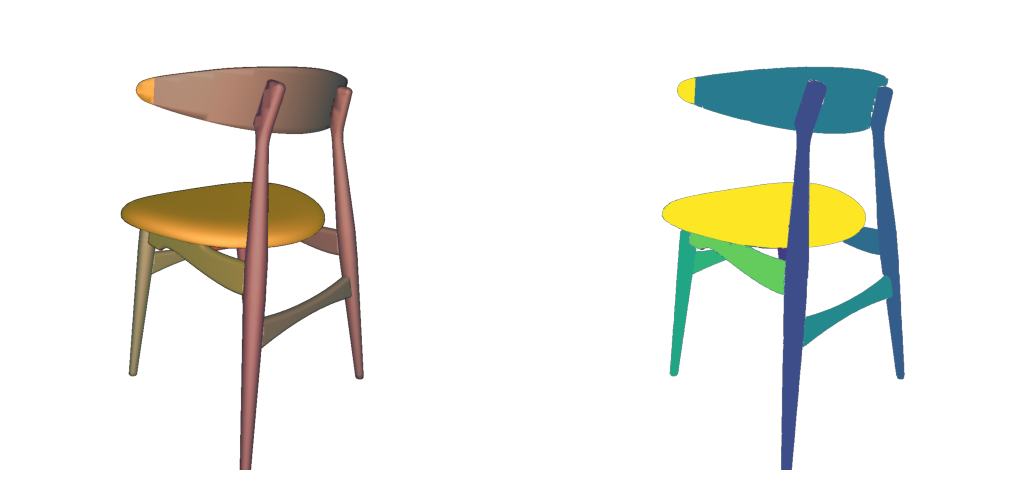

In [43]:
index = 2
img = data[index]['image'].clip(0, 1)
masks = []
for i in range(len(mask_gt[index])):
    tmp.zero_()
    tmp[tri_uni[index][0]] = mask_gt[index][i]
    masks.append(tmp[data[index]['tri_id']] > 0.5)
plt.figure(dpi=200)
plt.subplot(121)
show_masks(img, *masks)
plt.subplot(122)
show_masks(None, *masks)

In [8]:
M = sum(len(x) for x in all_masks)
print('the number of vaild masks', M)
N = 2 * max(len(x) for x in all_masks)
tree_nodes = torch.randn((N, num_faces + 1,), device=device)
tree_nodes.requires_grad_()
print('the maximum number of tree nodes:', N)

the number of vaild masks 1488
the maximum number of tree nodes: 50


将 $\{m^i_j\}$ 划分为$N$个类$M_n = \{m^n_1, m^n_2, \dots, m^n_{N_n}\}$, 使得下式最大化
$$\mathcal{L} = \frac{1}{N} \sum_{l=1}^{N}\frac{1}{N_n}\sum_{i=1}^{N_n}\mathrm{IoU}(m^l_i, P(M_l, \pi^l_i))$$
其中, $\pi^l_i$表示$m^l_i$对应的视角, $P(M, \pi)$表示三维分割$M$在视角$\pi$下的投影


In [15]:
@torch.no_grad()
def match(masks_1: Tensor, masks_2: Tensor):
    N1 = masks_1.shape[0]
    N2 = masks_2.shape[0]
    iou_matrix = torch.zeros((N1, N2), device=device)
    area_1 = masks_1.flatten(1).sum(dim=-1)
    area_2 = masks_2.flatten(1).sum(dim=-1)
    for i in range(N1):
        for j in range(N2):
            inter = (masks_1[i] * masks_2[j]).sum()
            # iou_matrix[i, j] = inter / max(area_1[i] + area_2[j] - inter, 1e-7)
            iou_matrix[i, j] = 2 * inter / (area_1[i] + area_2[j])
    # print('...', iou_matrix.min(), iou_matrix.max(), *area_1.aminmax(), *area_2.aminmax())
    match_1 = torch.zeros(N1, dtype=torch.int, device=device) - 1
    match_2 = torch.zeros(N2, dtype=torch.int, device=device) - 1
    match_iou = torch.zeros(N1, dtype=torch.float, device=device)
    for iou, index in zip(*iou_matrix.view(-1).sort(descending=True)):
        i, j = index // N2, index % N2
        assert 0 <= i < N1 and 0 <= j < N2
        if match_1[i] < 0 and match_2[j] < 0:
            match_1[i] = j
            match_2[j] = i
            match_iou[i] = iou
            # print(iou, i, j)
    # print('match_iou', match_iou)  #, iou_matrix.amax(dim=1))
    return match_1, match_2, match_iou


@torch.no_grad()
def match_tree(view_idx=0, return_iou=False):
    tri_id = data[view_idx]['tri_id']
    foreground = tri_id.gt(0)
    background = tri_id.eq(0)
    tree_masks = tree_nodes[:, tri_id].sigmoid()
    tree_masks = torch.cat([foreground[None], background[None], tree_masks], dim=0)
    # print('tree_masks', utils.show_shape(tree_masks), *tree_masks.aminmax())
    match_1, _, match_iou = match(all_masks[view_idx], tree_masks)
    if return_iou:
        return match_1, match_iou
    else:
        return match_1


def match_loss(view_idx=0):
    match_index = match_tree(view_idx)
    index_gt = torch.nonzero(match_index > 1)[:, 0]
    # print('index_gt:', utils.show_shape(index_gt), index_gt)
    assert 0 <= index_gt.min() and index_gt.max() < match_index.shape[0]
    index_pd = match_index[index_gt] - 2
    # print('index_pd:', utils.show_shape(index_pd), index_pd)
    assert 0 <= index_pd.min() and index_pd.max() < tree_nodes.shape[0]
    assert 0 <= tri_uni[view_idx][0].min() and tri_uni[view_idx][0].max() < tree_nodes.shape[1]
    prediction = tree_nodes[index_pd][:, tri_uni[view_idx][0]]
    # print(utils.show_shape(tree_nodes[index_pd], prediction))
    assert index_gt.max() < mask_gt[view_idx].shape[0]
    gt = mask_gt[view_idx][index_gt]
    # print(utils.show_shape(prediction, gt, mask_gt[view_idx], index_gt))
    # p_, g_ = prediction.sigmoid(), gt
    # inter = (g_ * p_).sum(dim=-1)
    # iou = 2 * inter / (g_.sum(dim=-1) + p_.sum(dim=-1))
    # print(iou)
    # assert 0 <= prediction.min() and prediction.max() <= 1.
    assert 0 <= gt.min() and gt.max() <= 1.
    return F.binary_cross_entropy_with_logits(prediction, gt)


print(match(all_masks[0], all_masks[1]))
print(match_tree(0))
print(match_loss(0))

(tensor([ 0,  8, 10,  1,  2, 11,  5, 12,  7,  9,  4,  6, 13, 14,  3],
       device='cuda:0', dtype=torch.int32), tensor([ 0,  3,  4, 14, 10,  6, 11,  8,  1,  9,  2,  5,  7, 12, 13, -1],
       device='cuda:0', dtype=torch.int32), tensor([0.0000, 0.1382, 0.0713, 0.7926, 0.8151, 0.6810, 0.2729, 0.2003, 0.6830,
        0.8179, 0.6695, 0.6827, 0.8037, 0.8348, 0.0000], device='cuda:0'))
tensor([29, 51,  3,  0,  8, 40, 11, 15,  7,  4, 16,  2, 18, 21,  6],
       device='cuda:0', dtype=torch.int32)
tensor(0.7928, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


In [10]:

class Tree3D_(TreeStructure):
    def __init__(self, mesh: ext.Mesh, verbose=0, device=None):
        self.mesh = mesh
        v3 = mesh.v_pos[mesh.f_pos]  # shape: (F, 3, 3)
        self.area = torch.cross(v3[:, 0] - v3[:, 1], v3[:, 0] - v3[:, 2], dim=-1).norm(dim=-1) * 0.5
        self.num_faces = mesh.f_pos.shape[0]

        self.nodes_info = [{}]
        super().__init__(1, device=device, verbose=verbose)
        self.score_nodes = 0
        self.score_2d = 0
        self.score_3d = 0

        self.ignore_area = 0.5
        self.threshold_score = 0.5

    def reset(self):
        self.score_nodes = 0
        super().reset()
        self.nodes_info = [{} for _ in range(self.cnt + 1)]

    def resize(self, N: int):
        N, M = super().resize(N)
        if N < M:
            self.nodes_info = self.nodes_info[:N]
        elif N > M:
            self.nodes_info.extend([{} for _ in range(N - M)])

    def node_rearrange(self, indices=None):
        indices, new_indices = super().node_rearrange(indices)
        new_node_info = [{} for _ in range(self.cnt + 1)]
        for i, j in zip(indices, new_indices):
            i, j = i.item(), j.item()
            new_node_info[j] = self.nodes_info[i]
        self.nodes_info = new_node_info

    def node_new(self):
        if self.cnt + 1 == len(self.parent):
            self.resize(self.cnt + 10)
        index = super().node_new()
        # print(index, len(self.nodes_info))
        while len(self.nodes_info) <= index:
            self.nodes_info.append({})
        self.nodes_info[index] = {}
        return index

    def get_aux_data(self, tri_id: Tensor):
        tmp = torch.zeros(self.num_faces + 1, dtype=torch.int, device=self.device)
        aux_data = {}
        for nodes in self.get_levels():
            for x in nodes:
                if x == 0:
                    continue
                faces = self.nodes_info[x]['faces']
                tmp[faces] = x
                mask = tmp[tri_id].eq(x)
                area = mask.sum().item()
                if area >= self.ignore_area:
                    aux_data[x.item()] = (mask, area)
        mask = tri_id > 0
        aux_data[0] = (mask, mask.sum().item())
        aux_data['tri_id'] = tri_id
        # print('[Tree3D] get_aux_data:', utils.show_shape(aux_data))
        # print(f'There are {len(aux_data) - 1} segmented masks')
        return aux_data

    def get_level(self, aux_data: dict = None, root=0, depth=1, include_faces=False):
        results = self.get_levels(aux_data, root, depth, include_faces)
        return results[depth] if len(results) > depth else torch.tensor([])

    def get_levels(self, aux_data: dict = None, root=0, depth=-1, include_faces=False):
        levels = super().get_levels(root=root, depth=depth)
        # logger.WARN(f'[Tree3D] levels without auxdata:', levels)
        if aux_data is not None:
            levels = [level.new_tensor([x for x in level if x.item() in aux_data]) for level in levels]
        # if include_faces:
        #     faces = torch.unique(aux_data['tri_id'])
        #     parents = self.face_parent[faces]
        #     levels.append(torch.tensor([], dtype=torch.int, device=self.device))
        #     for i, level in reversed(list(enumerate(levels))):
        #         levels[i + 1] = torch.cat([levels[i + 1]] + [faces[parents == x] for x in level])
        levels = [level for level in levels if level.numel() > 0]
        # if self.verbose > 1 or (self.verbose == 1 and depth < 0):
        #     logger(f'[Tree3D] get {len(levels)} levels')
        return levels

    # def node_insert(self, idx: int, parent: int):
    #     super().node_insert(idx, parent)
    #     mask = torch.zeros(self.num_faces + 1, dtype=torch.bool, device=self.device)
    #     mask[self.nodes_info[idx]['faces']] = 1

    def insert(self, mask: Tensor, area: float, now: int, root=0):
        node_in = []
        in_node = []
        for c in self.get_children(root):
            assert self.nodes_info[c]['faces'].max() <= self.area.shape[0]
            inter = (mask[self.nodes_info[c]['faces']] * self.area[self.nodes_info[c]['faces'] - 1]).sum().item()
            area_c = self.nodes_info[c]['area']
            in_now = inter / area
            in_c = inter / area_c
            iou = inter / (area + area_c - inter)
            if in_now > in_c:
                node_in.append((c, in_now, in_c))
            else:
                in_node.append((c, in_now, in_c))

        if len(node_in) == 0:
            # now = self.node_new()
            self.node_insert(now, root)
            for c, in_now, in_c in in_node:
                if self.nodes_info[c]['in'] < in_now:
                    self.nodes_info[c]['in'] = in_now
                    self.node_move(c, now)
            if root == 0:
                inter = area
            else:
                faces = self.nodes_info[root]['faces']
                assert 1 <= faces.min() and faces.max() <= self.area.shape[0]
                inter = (mask[faces] * self.area[faces - 1]).sum().item()
            self.nodes_info[now] = {
                'faces': torch.nonzero(mask),
                'area': area,
                'in': inter / area,
            }
            return now
        else:
            max_c, max_v, _ = node_in[0]
            for c, in_now, in_c in node_in:
                if in_now > max_v:
                    max_c = c
                    max_v = in_now
            return self.insert(mask, area, now, max_c)

    def remove(self, index: int):
        self.node_delete(index, move_children=True)


In [11]:
tree = Tree3D_(mesh)
tree.resize(N + 1)


def make_tree():
    tree.reset()
    for i in range(N):
        mask = tree_nodes[i] > 0  # tree.threshold_score
        mask[0] = 0
        area = (mask[1:] * tree.area).sum().item()
        index = tree.node_new()
        if area > 0:
            tree.insert(mask, area, index)
    return tree


t = make_tree()
t.print_tree()
print(t.cnt)

0: Tree Root
├── 21
│   ├── 28
│   │   ├── 39
│   │   │   └── 44
│   │   ├── 31
│   │   │   ├── 34
│   │   │   └── 32
│   │   └── 29
│   │       └── 30
│   ├── 25
│   │   ├── 45
│   │   │   └── 46
│   │   │       └── 48
│   │   ├── 43
│   │   └── 42
│   │       └── 50
│   └── 22
│       └── 23
│           └── 24
├── 17
│   ├── 37
│   │   └── 47
│   ├── 36
│   │   └── 40
│   ├── 20
│   │   └── 26
│   │       ├── 38
│   │       └── 35
│   └── 19
│       ├── 33
│       └── 27
├── 9
│   ├── 16
│   │   └── 49
│   ├── 11
│   │   ├── 41
│   │   └── 14
│   │       └── 15
│   └── 10
│       └── 13
├── 2
│   ├── 8
│   │   └── 18
│   │       └── 12
│   ├── 6
│   └── 4
│       ├── 7
│       └── 3
│           └── 5
└── 1

50


In [12]:
def tree_loss():
    pass

最大化树结构评分: 兄弟结点互不重叠, 结点全部在父结点中

$$\mathcal{L}_{structure} = \frac{1}{N}\left(\frac{1}{|C(p)|(|C(p)|-1)}\sum_{i, j \in C(p)}1- \mathrm{IoU}(T_i, T_j) + \sum_{i}{\mathrm{In}(T_i, T_{p_i})}\right)$$

$C(p)$表示节点$p$的所有子节点

In [13]:
def tree_structure_loss(tree: Tree3D_, eps=1e-7, smooth=1.):
    losses = 0
    for p in range(1, tree.cnt + 1):
        children = torch.tensor(tree.get_children(p), dtype=torch.long, device=device)
        if children.numel() > 0:
            assert 0 < children.min() and children.max() <= tree_nodes.shape[
                0], f"children {children}, {tree_nodes.shape[0]}"
            scores_c = tree_nodes[children - 1]
            # print(scores_c.shape)
            intersection = (scores_c[:, None, :] * scores_c[None, :, :]).sum(dim=-1)
            cardinality = torch.sum(scores_c[:, None, :] + scores_c[None, :, :], dim=-1)
            dice_loss = (1 - 2. * (intersection + smooth) / (cardinality + smooth)).mean()
        else:
            dice_loss = 0.

        pp = tree.parent[p].item()
        if pp <= 0:
            p_loss = 0
        else:
            assert 0 < pp <= tree_nodes.shape[0], f"{pp}"
            intersection = torch.sum(tree_nodes[p - 1] * tree_nodes[pp - 1])
            cardinality = torch.sum(tree_nodes[p - 1] + tree_nodes[pp - 1])
            p_loss = 1 - 2 * (intersection + smooth) / (cardinality + smooth)
        # print(dice_loss, p_loss)
        losses = losses + dice_loss + p_loss
    return losses / tree.cnt


print(tree_structure_loss(t))

tensor(-74.9442, device='cuda:0', grad_fn=<DivBackward0>)


In [28]:
nn.init.normal_(tree_nodes, 0, 1)
opt = torch.optim.SGD([tree_nodes], lr=1)
# opt = torch.optim.Adam([tree_nodes], lr=1e-3)
view_indices = np.arange(len(data))
for epoch in range(100):
    np.random.shuffle(view_indices)
    total_loss = 0
    for step in view_indices:
        with torch.no_grad():
            make_tree()
        loss = match_loss(step) * 100  # + 0 * tree_structure_loss(t)
        loss.backward()
        opt.step()
        total_loss += loss.item()
        x, y = match_tree(0, return_iou=True)
        print(y.mean(), tree_nodes[x[0]])
        break
        print(f"\rloss: {loss.item():.6f}   ", end='')
    print(f'\repoch {epoch} avg loss: {total_loss / len(view_indices):.6f}')

tensor(0.0748, device='cuda:0') tensor([-1.2819,  1.0717, -0.5422,  ...,  0.1318,  1.8803, -0.7677],
       device='cuda:0', grad_fn=<SelectBackward0>)
epoch 0 avg loss: 0.806059
tensor(0.0747, device='cuda:0') tensor([-1.2819,  1.0714, -0.5426,  ...,  0.1311,  1.8799, -0.7681],
       device='cuda:0', grad_fn=<SelectBackward0>)
epoch 1 avg loss: 0.805267
tensor(0.0747, device='cuda:0') tensor([-1.2819,  1.0711, -0.5429,  ...,  0.1304,  1.8795, -0.7686],
       device='cuda:0', grad_fn=<SelectBackward0>)
epoch 2 avg loss: 0.803725
tensor(0.0747, device='cuda:0') tensor([-1.2819,  1.0708, -0.5433,  ...,  0.1297,  1.8791, -0.7690],
       device='cuda:0', grad_fn=<SelectBackward0>)
epoch 3 avg loss: 0.802024
tensor(0.0747, device='cuda:0') tensor([-1.2819,  1.0705, -0.5437,  ...,  0.1290,  1.8788, -0.7695],
       device='cuda:0', grad_fn=<SelectBackward0>)
epoch 4 avg loss: 0.802849
tensor(0.0747, device='cuda:0') tensor([-1.2819,  1.0702, -0.5440,  ...,  0.1283,  1.8784, -0.7700],
    

In [16]:
print(match_tree(0, return_iou=True)[1])
t.print_tree()

tensor([0.0008, 0.0858, 0.0106, 0.5252, 0.0237, 0.0179, 0.0509, 0.1034, 0.0126,
        0.0577, 0.0276, 0.0338, 0.0085, 0.0135, 0.0016], device='cuda:0')


0: Tree Root
├── 22
│   ├── 43
│   │   └── 31
│   │       ├── 38
│   │       │   └── 36
│   │       │       ├── 45
│   │       │       │   └── 47
│   │       │       └── 37
│   │       │           └── 39
│   │       └── 26
│   │           └── 33
│   │               └── 35
│   │                   └── 41
│   │                       └── 50
│   └── 23
├── 13
│   ├── 48
│   │   └── 49
│   ├── 40
│   │   └── 44
│   │       └── 46
│   ├── 19
│   │   ├── 34
│   │   ├── 28
│   │   │   └── 30
│   │   │       └── 29
│   │   ├── 21
│   │   │   └── 25
│   │   └── 20
│   └── 18
├── 8
│   ├── 42
│   └── 12
│       └── 9
│           ├── 16
│           │   ├── 27
│           │   │   └── 32
│           │   └── 11
│           │       ├── 17
│           │       │   └── 24
│           │       └── 14
│           │           └── 15
│           └── 10
├── 4
│   └── 5
│       ├── 7
│       └── 6
├── 3
├── 2
└── 1

In [41]:
t_save = Tree3D(mesh, device=device)
t_save.resize(t.cnt + 1)
node_map = {-1: -1, 0: 0}
for nodes in t.get_levels():
    for x in nodes:
        if x == 0:
            continue
        node_map[x.item()] = t_save.node_new()
print(node_map)
for nodes in t.get_levels():
    for x in nodes:
        x = x.item()
        now = node_map[x]
        t_save.parent[now] = node_map[t.parent[x].item()]
        t_save.first[now] = node_map[t.first[x].item()]
        t_save.last[now] = node_map[t.last[x].item()]
        t_save.next[now] = node_map[t.next[x].item()]
        assert 0 <= x <= tree_nodes.shape[0]
        if x > 0:
            mask = tree_nodes[x - 1] > 0
            t_save.face_parent[mask] = now

t_save.print_tree()
print(t_save.parent)
print(t_save.first)
t_save.save(save_root.joinpath('tree_3d.pth'))

[Tree] reset
[Tree] Resize tree from 1 to 51
{-1: -1, 0: 0, 43: 1, 29: 2, 25: 3, 19: 4, 15: 5, 6: 6, 5: 7, 1: 8, 49: 9, 21: 10}


0: Tree Root
├── 1
│   └── 9
├── 2
├── 3
├── 4
│   └── 10
├── 5
├── 6
├── 7
└── 8

tensor([-1,  0,  0,  0,  0,  0,  0,  0,  0,  1,  4, -1, -1, -1, -1, -1, -1, -1,
        -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
        -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1],
       device='cuda:0', dtype=torch.int32)
tensor([ 1,  9, -1, -1, 10, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
        -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
        -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1],
       device='cuda:0', dtype=torch.int32)
[Tree3D]save now Tree3D to /home/wan/wan_code/segmentation/segment_anything/results/cbec970966b1cfc31013390074d5de0a/tree_3d.pth


In [4]:
from pathlib import Path
import scipy.io as scio
import matplotlib.pyplot as plt
import matplotlib

voc_part_root = Path('/data/VOC/Part2010/Annotations_Part')
ann_files = list(voc_part_root.glob('*.mat'))
ann_files = sorted(ann_files)
print(ann_files[0])
data = scio.loadmat(ann_files[0])
print(type(data))

/data/VOC/Part2010/Annotations_Part/2008_000002.mat
<class 'dict'>


In [81]:
from tqdm import tqdm

data = []
for ann_file in tqdm(ann_files):
    annotations = scio.loadmat(ann_file)['anno'][0]
    assert len(annotations) == 1
    info = {
        'filename': annotations[0][0][0],
        'objects': []
    }
    objects = annotations[0][1][0]
    # print(f"{filename} have {len(objects)} objects")
    for obj in objects:
        info['objects'].append({
            'class': obj[0][0],
            'class_ind': obj[1][0],
            'mask': obj[2],
            'parts': [(part[0][0], part[1]) for part in obj[3][0]] if len(obj[3]) > 0 else []
        })
    # print(utils.show_shape(info))
    data.append(info)

100%|██████████| 10103/10103 [02:02<00:00, 82.50it/s] 


{'filename': '2008_000009', 'objects': [{'class': 'cow', 'class_ind': numpy((1,), uint8), 'mask': numpy((375, 500), uint8), 'parts': [('head', numpy((375, 500), uint8)), ('lear', numpy((375, 500), uint8)), ('leye', numpy((375, 500), uint8)), ('muzzle', numpy((375, 500), uint8)), ('torso', numpy((375, 500), uint8)), ('neck', numpy((375, 500), uint8)), ('lflleg', numpy((375, 500), uint8)), ('lfuleg', numpy((375, 500), uint8)), ('rflleg', numpy((375, 500), uint8)), ('rfuleg', numpy((375, 500), uint8)), ('lblleg', numpy((375, 500), uint8)), ('lbuleg', numpy((375, 500), uint8)), ('rblleg', numpy((375, 500), uint8))]}, {'class': 'cow', 'class_ind': numpy((1,), uint8), 'mask': numpy((375, 500), uint8), 'parts': [('torso', numpy((375, 500), uint8)), ('lflleg', numpy((375, 500), uint8)), ('lfuleg', numpy((375, 500), uint8)), ('lblleg', numpy((375, 500), uint8)), ('lbuleg', numpy((375, 500), uint8)), ('rblleg', numpy((375, 500), uint8)), ('rbuleg', numpy((375, 500), uint8)), ('tail', numpy((375,

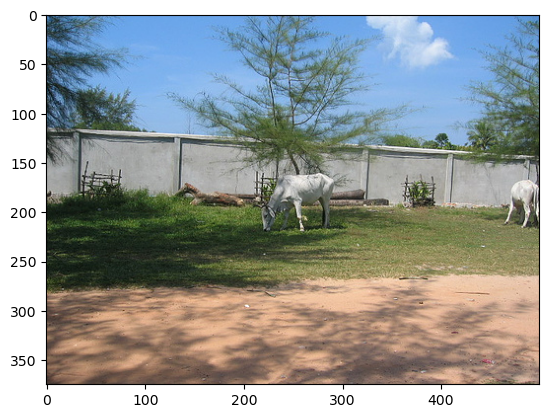

In [91]:
index = 4
print(utils.show_shape(data[index]))
img_root = Path('/data/VOC/VOC2010/JPEGImages')
img = plt.imread(img_root.joinpath(data[index]['filename'] + '.jpg'))
plt.imshow(img)
plt.show()

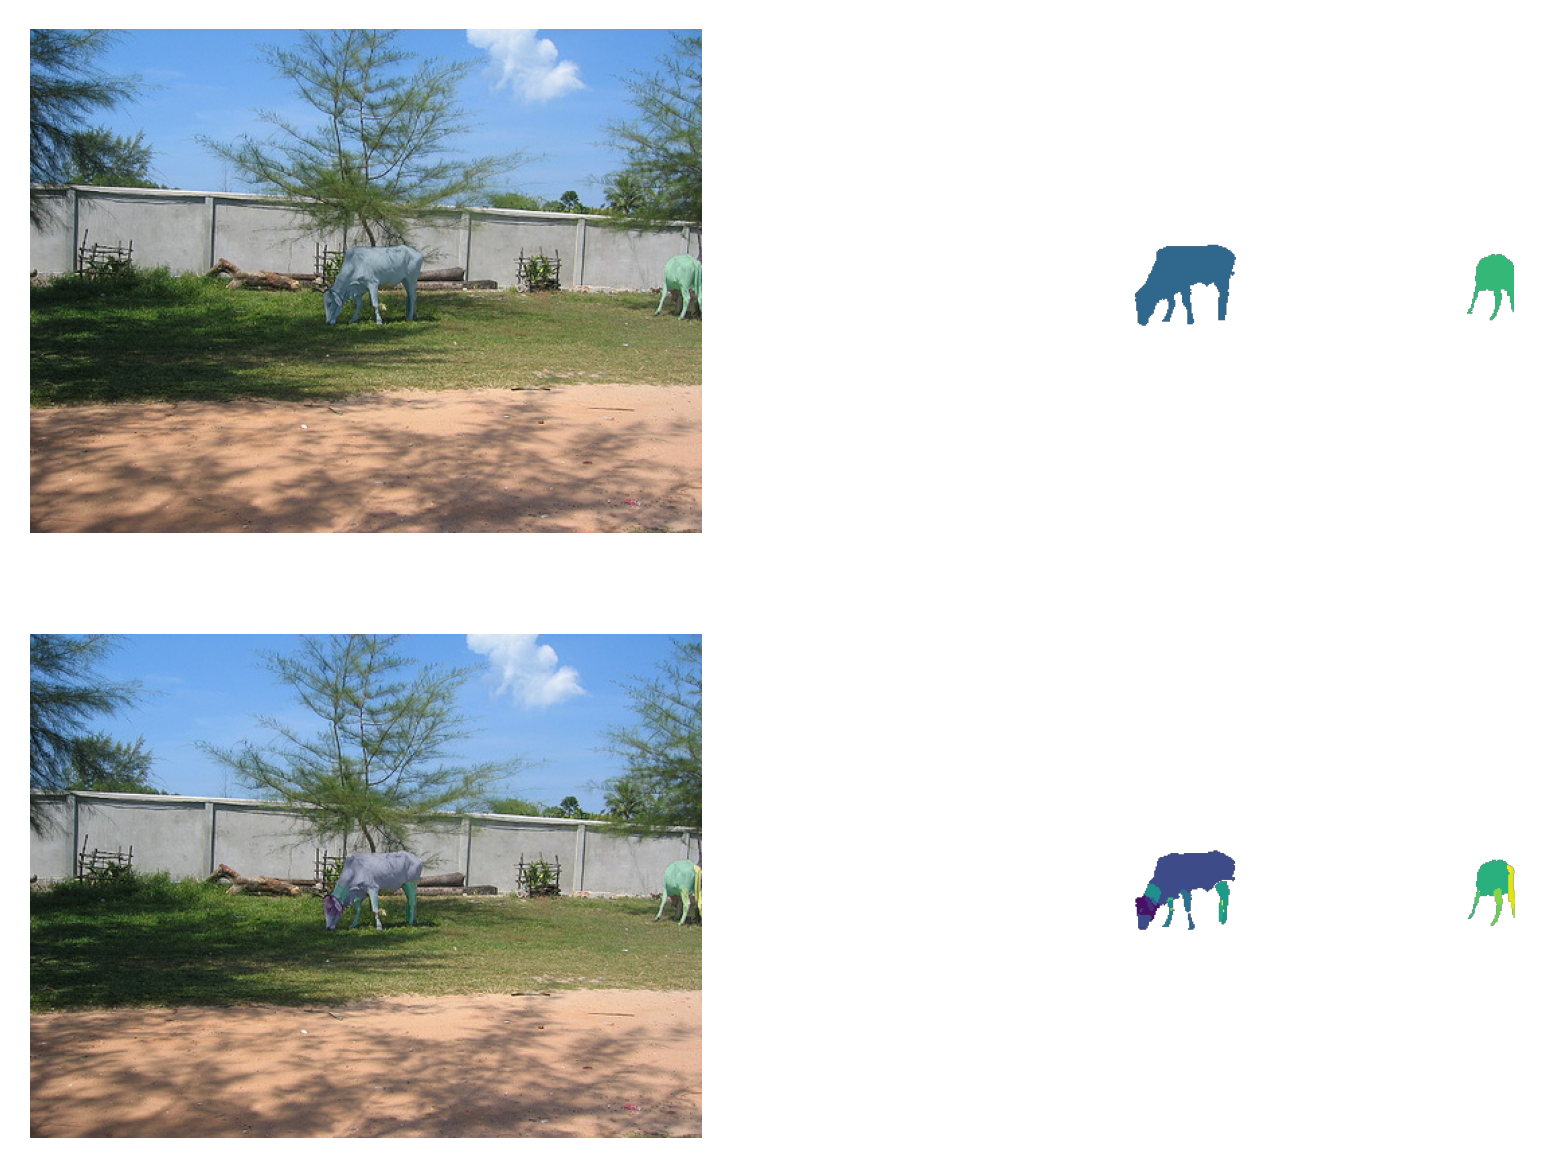

In [92]:
masks = [obj['mask'] for obj in data[index]['objects']]
plt.figure(dpi=300)
plt.subplot(221)
show_masks(img, *masks)
plt.subplot(222)
show_masks(None, *masks)
part_masks = []
for obj in data[index]['objects']:
    part_masks.extend(part[1] for part in obj['parts'])
plt.subplot(223)
show_masks(img, *part_masks)
plt.subplot(224)
show_masks(None, *part_masks)

In [90]:
class_seg_root = Path('/data/VOC/VOC2010/SegmentationClassAug')
mask_path = class_seg_root.joinpath(data[index]['filename'] + '.png')
if mask_path.exists():
    mask_cls = plt.imread(mask_path)
    plt.subplot(121)
    show_masks(img, mask_cls)
    plt.subplot(122)
    show_masks(None, mask_cls)

In [58]:
class_obj_root = Path('/data/VOC/VOC2010/SegmentationObject')
mask_obj = plt.imread(class_obj_root.joinpath(filename + '.png'))
plt.subplot(121)
show_masks(img, mask_obj)
plt.subplot(122)
show_masks(None, mask_obj)

FileNotFoundError: [Errno 2] No such file or directory: '/data/VOC/VOC2010/SegmentationObject/2008_000003.png'

In [9]:
from collections import defaultdict

face_dataset_root = Path('/data6/CelebAMask-HQ')
img_root = face_dataset_root.joinpath('CelebA-HQ-img')
part_root = face_dataset_root.joinpath('CelebAMask-HQ-mask-anno')

face_data = defaultdict(list)
for part_filepath in part_root.rglob('*_*.png'):
    image_id = int(part_filepath.name.split('_')[0])
    face_data[image_id].append(part_filepath.name)
    assert int(part_filepath.parts[-2]) == image_id // 2000
print(f'There are {len(face_data)} images')


There are 30000 images


index=1976
image: numpy((1024, 1024, 3), uint8)
12 numpy((512, 512, 3), uint8) [  0 255]


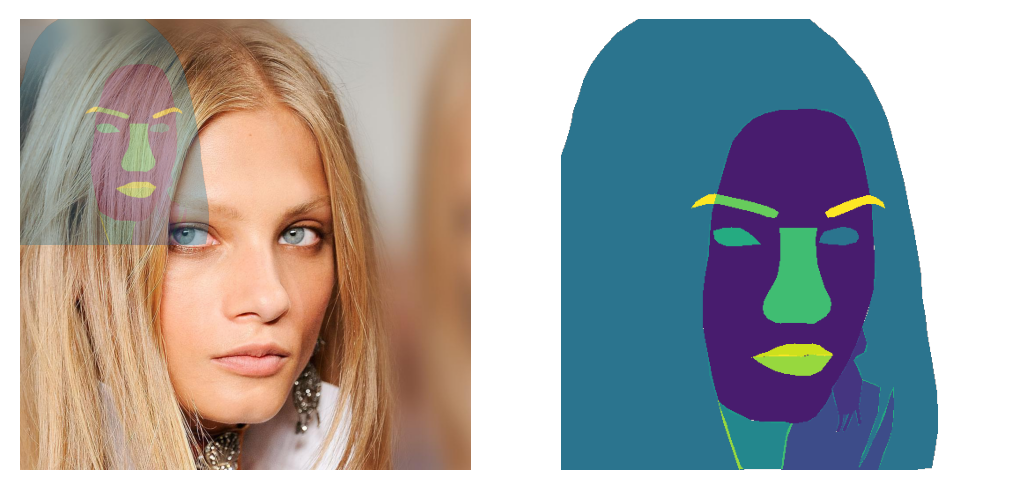

In [18]:
index = np.random.randint(30000)
print(f"index={index}")
img = utils.load_image(img_root.joinpath(f"{index}.jpg"))
print('image:', utils.show_shape(img))
parts = [utils.load_image(part_root.joinpath(f"{index // 2000}", part_name)) for part_name in face_data[index]]
print(len(parts), utils.show_shape(parts[0]), np.unique(parts[0]))
parts = [part[:, :, 0] > 0 for part in parts]
plt.figure(dpi=200)
plt.subplot(121)
show_masks(img, *parts)
plt.subplot(122)
show_masks(None, *parts)